# Housing Price Prediction
Let's build a model to predict house prices, using the Ames, Iowa dataset.

## Setup and Exploratory Data Analysis

In [2301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, SelectFromModel

import xgboost as xgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
sns.set_theme()

First, let's have a look at the features.  

In [2302]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
X = train_df.drop("SalePrice", axis=1)
y = train_df["SalePrice"]
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2303]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [2304]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


A lot of the zero values appear to mean that the item is missing.  

In [2305]:
cols_with_missing = X.isna().sum()
cols_with_missing[cols_with_missing > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

This makes sense, a lot of houses won't have pools, alleys, fireplaces,  etc...

In [2306]:
X.duplicated().sum()

np.int64(0)

In [2307]:
train_df.corrwith(train_df.SalePrice, numeric_only=True).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float

## Initial Data Visualization

In [2308]:
num_cols_to_plot = train_df.drop(["Id", "SalePrice"], axis=1).select_dtypes(include="number").columns
cat_cols_to_plot = train_df.drop(["Id", "Neighborhood", "Exterior1st", "Exterior2nd"], axis=1).select_dtypes(include="object").columns

Let's graph the distributions of the categorical features with respect to the sale price.  I am omitting some features that are not usefule (Id) as well as some that have a high number of categories due to legend formatting issues on these small plots.  

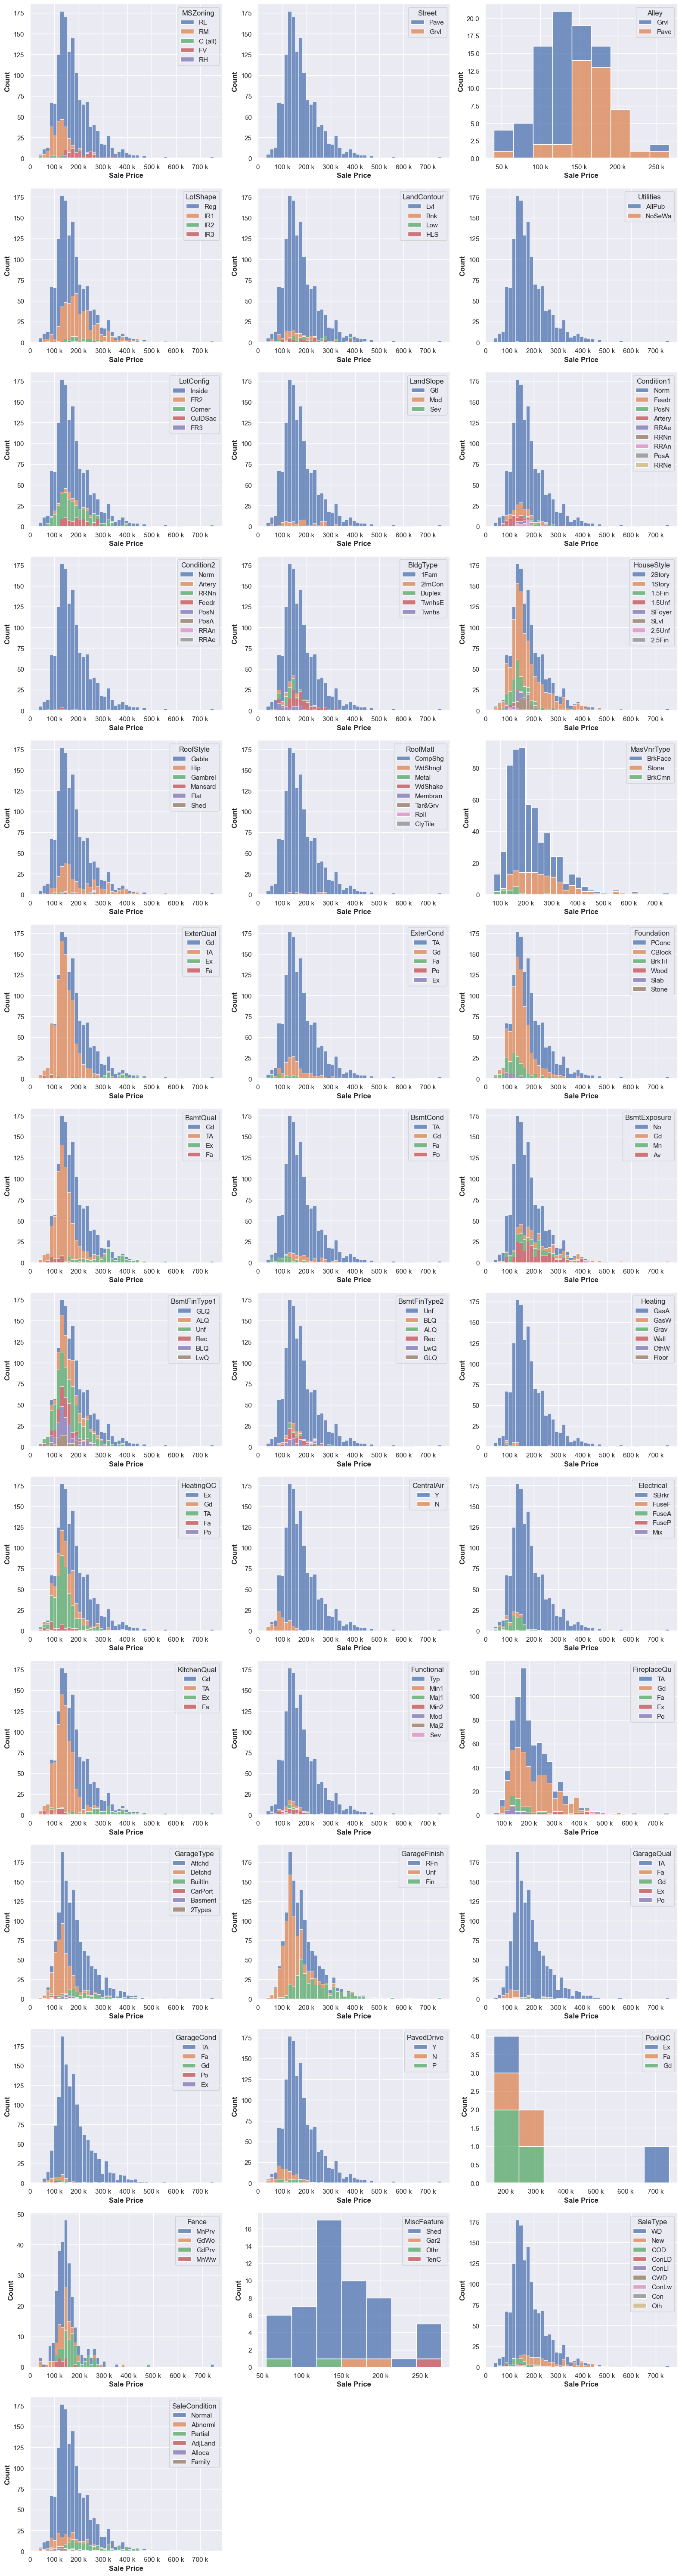

In [2309]:
plt.figure(figsize=(16, 60))
for i, col in enumerate(cat_cols_to_plot):
    ax = plt.subplot(14, 3, i+1)
    sns.histplot(data=train_df, hue=col, x="SalePrice", multiple="stack")
    ax.set_xlabel("Sale Price", fontsize=12, fontweight="bold")
    ax.set_ylabel("Count", fontsize=12, fontweight="bold" )
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

plt.tight_layout()
plt.show()

Sale price is positively skewed, which is unsurprising given the dataset.  Lets graph some regressions.  

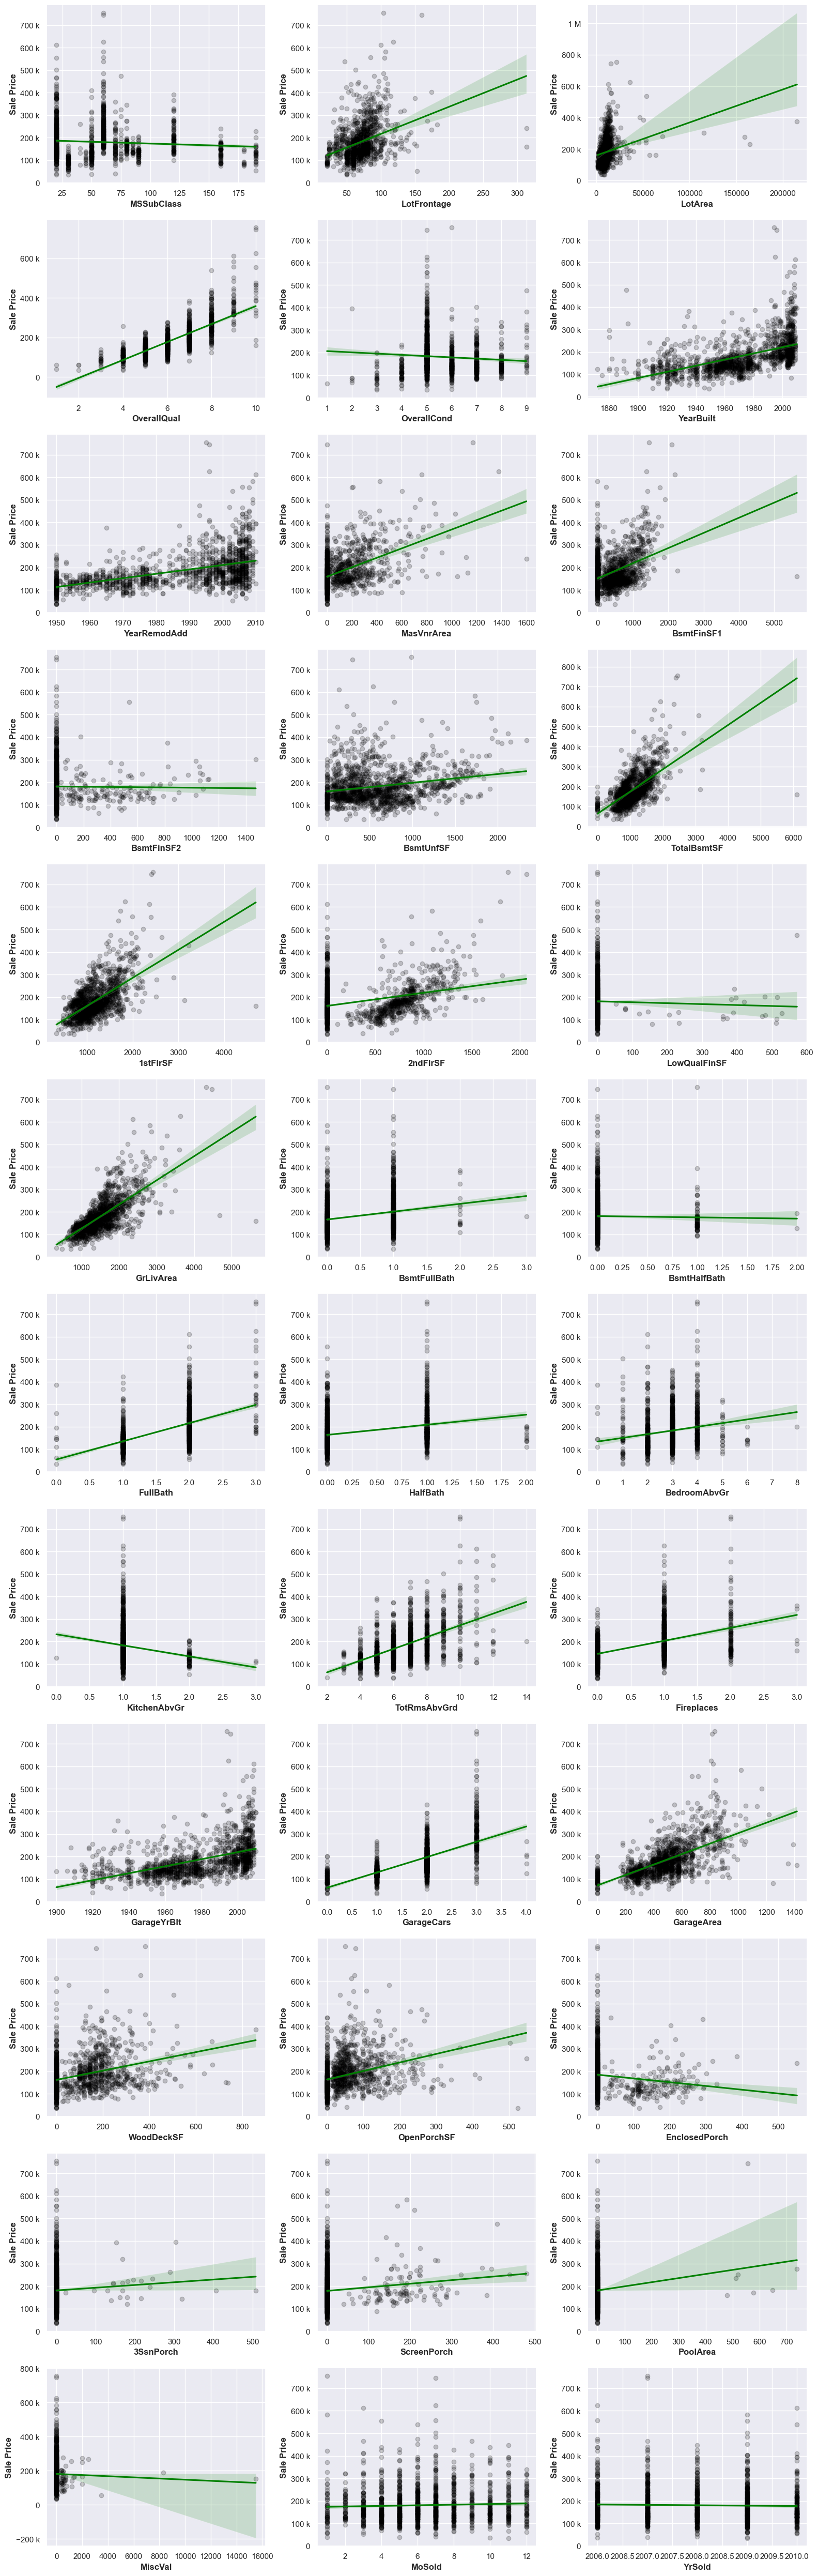

In [2310]:
plt.figure(figsize=(16, 50))
for i, col in enumerate(num_cols_to_plot):
    ax = plt.subplot(12, 3, i+1)
    sns.regplot(data=train_df, x=col, y="SalePrice", scatter_kws={"alpha": 0.2, "color": "black"}, line_kws={"color": "green"})
    ax.set_xlabel(col, fontsize=12, fontweight="bold")
    ax.set_ylabel("Sale Price", fontsize=12, fontweight="bold")
    ax.yaxis.set_major_formatter(ticker.EngFormatter())

plt.tight_layout()
plt.show()

In general, quality and size seem to affect sale price more than anything.  I am curious to see how neighborhood relates to sale price (we omitted this above).

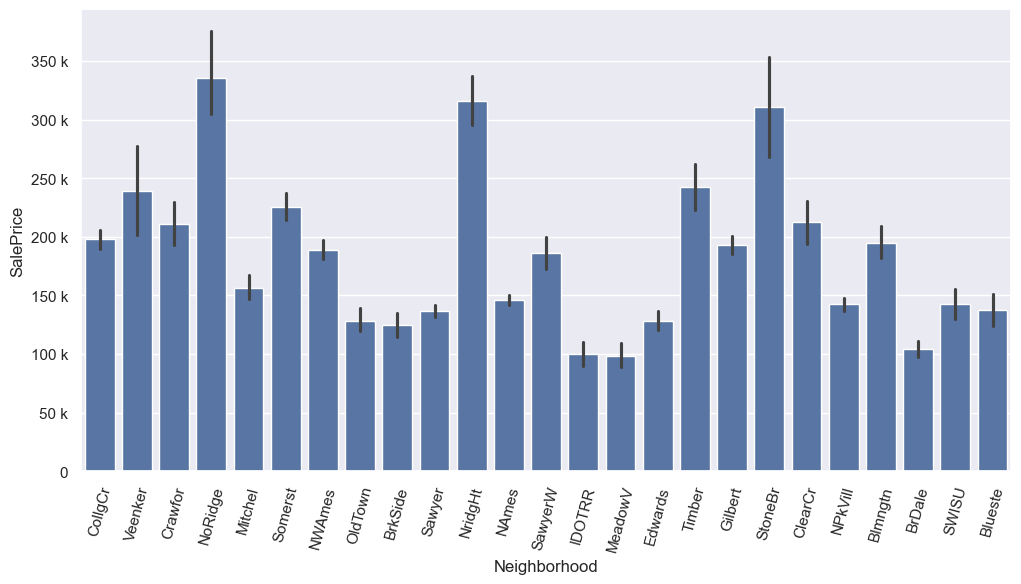

In [2311]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=train_df, y="SalePrice", x="Neighborhood")
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.show()

## Data Preprocessing and Feature Engineering

First, let's convert MSSubclass to an object, it doesn't make sense to leave it as a number since there is no ordinal relationship between the values.  

In [2312]:
X.MSSubClass = X.MSSubClass.astype("object")
test_df.MSSubClass = test_df.MSSubClass.astype("object")

In general, we'll handle removing features later, but Id can go now since it's just a redundant index, and PoolQC has so few values that it's just going to be noise.  

In [2313]:
cols_to_drop = ["Id", "PoolQC"]
X = X.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop[1:], axis=1)

Features of the object type will be categorical.  

In [2314]:
cat_features = X.select_dtypes(include="object").columns

Ordinal features are a subset of categorical that imply an order.  By handling these appropriately we can feed useful information into the model.  Let's start by identifying them and their unique values.  

In [2315]:
ordinal_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
                    "FireplaceQu", "GarageQual", "GarageCond"]


In [2316]:
for cat in ordinal_features:
    print(f"Feature: {cat}, Values: {X[cat].unique()}")

Feature: ExterQual, Values: ['Gd' 'TA' 'Ex' 'Fa']
Feature: ExterCond, Values: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
Feature: BsmtQual, Values: ['Gd' 'TA' 'Ex' nan 'Fa']
Feature: BsmtCond, Values: ['TA' 'Gd' nan 'Fa' 'Po']
Feature: HeatingQC, Values: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
Feature: KitchenQual, Values: ['Gd' 'TA' 'Ex' 'Fa']
Feature: FireplaceQu, Values: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Feature: GarageQual, Values: ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
Feature: GarageCond, Values: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


Since they all share a common spectrum of values, this should be pretty straighforward.  We'll create a list of ordered ordinal categories to pass to an OrdinalEncoder later.  

In [2317]:
ordinal_categories = [["Missing", "Po", "Fa", "TA", "Gd", "Ex"]] * len(ordinal_features)
ordinal_categories


[['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]

We will use One Hot encoding to handle most nominal features (categorical but not ordinal).  Some of the nominal features have quite a few unique values.  It might be better to identify these and handle them with target mean encoding (imposing ordinality on them through their relationship with the target - sale price).

In [2318]:
nominal_features_high_cardinality = ["Neighborhood", "Exterior1st", "Exterior2nd", "MSSubClass", "MSZoning"]
nominal_features = [f for f in cat_features if f not in ordinal_features and f not in nominal_features_high_cardinality]

In [2319]:
nominal_features

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Now on to the numeric features.  Let's start by consolidating a bunch of these features down to a smaller set.  

In [2320]:
X["HouseAge"] = X.YrSold - X.YearBuilt
test_df["HouseAge"] = test_df.YrSold - test_df.YearBuilt

X["GarageAge"] = X.YrSold - X.GarageYrBlt
test_df["GarageAge"] = test_df.YrSold - test_df.GarageYrBlt

X["TotalLotArea"] = X.LotFrontage + X.LotArea
test_df["TotalLotArea"] = test_df.LotFrontage + test_df.LotArea

X["TotalPorchSf"] = X.OpenPorchSF + X.EnclosedPorch + X["3SsnPorch"] + X.ScreenPorch
test_df["TotalPorchSf"] = test_df.OpenPorchSF + test_df.EnclosedPorch + test_df["3SsnPorch"] + test_df.ScreenPorch

X["TotalArea"] = X.TotalBsmtSF + X["1stFlrSF"] + X["2ndFlrSF"]
test_df["TotalArea"] = test_df.TotalBsmtSF + test_df["1stFlrSF"] + test_df["2ndFlrSF"]

X["TotalBathrooms"] = X.FullBath + X.BsmtFullBath + (0.5 * (X.HalfBath + X.BsmtHalfBath))
test_df["TotalBathrooms"] = test_df.FullBath + test_df.BsmtFullBath + (0.5 * (test_df.HalfBath + test_df.BsmtHalfBath))

X["QualGr"] = X.OverallQual * (X.GrLivArea - X.LowQualFinSF)
test_df["QualGr"] = test_df.OverallQual * (test_df.GrLivArea - test_df.LowQualFinSF)

redundant_cols = ["YrSold", "YearBuilt", "GarageYrBlt", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath", "LotFrontage", 
                  "LotArea", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]
X = X.drop(redundant_cols, axis=1)
test_df = test_df.drop(redundant_cols, axis=1)

In [2321]:
numeric_features = X.select_dtypes(include="number").columns

Let's see how many na values we have in our categorical features.  

In [2322]:
X[cat_features].isna().sum()[X[cat_features].isna().sum() > 0]

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
Fence           1179
MiscFeature     1406
dtype: int64

In most cases, the na values probably just mean that the feature is not present, so we will replace these missing values with "Missing".  If you remember, we has set the list of ordinal categories above to begin with "Missing" which will signal to the model that a missing feature is of lower value than a present feature, regardless of quality.  

In [2323]:
X[cat_features] = X[cat_features].fillna("Missing")
test_df[cat_features] = test_df[cat_features].fillna("Missing")

Now let's put this all together in a preprocessing ColumnTransformer.  

In [2324]:
num_imputer = KNNImputer(n_neighbors=5)
oh_encoder = OneHotEncoder(handle_unknown="ignore")
ord_encoder = OrdinalEncoder(categories=ordinal_categories)
targ_enconder = TargetEncoder(target_type="continuous", random_state=0)

preprocessor = ColumnTransformer([
    ("targ_encoder", targ_enconder, nominal_features_high_cardinality),
    ("impute_num", num_imputer, numeric_features),
    ("oh_encoder", oh_encoder, nominal_features),
    ("ord_encoder", ord_encoder, ordinal_features)
], remainder="passthrough")# , sparse_threshold=0)

Let's see what the columns look like after preprocessing.  

In [2325]:
X_transformed = preprocessor.fit_transform(X, y)
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
X_transformed.head()

,targ_encoder__Neighborhood,targ_encoder__Exterior1st,targ_encoder__Exterior2nd,targ_encoder__MSSubClass,targ_encoder__MSZoning,impute_num__OverallQual,impute_num__OverallCond,impute_num__YearRemodAdd,impute_num__MasVnrArea,impute_num__BsmtFinSF1,impute_num__BsmtFinSF2,impute_num__BsmtUnfSF,impute_num__LowQualFinSF,impute_num__GrLivArea,impute_num__BedroomAbvGr,impute_num__KitchenAbvGr,impute_num__TotRmsAbvGrd,impute_num__Fireplaces,impute_num__GarageCars,impute_num__GarageArea,impute_num__WoodDeckSF,impute_num__PoolArea,impute_num__MiscVal,impute_num__MoSold,impute_num__HouseAge,impute_num__GarageAge,impute_num__TotalLotArea,impute_num__TotalPorchSf,impute_num__TotalArea,impute_num__TotalBathrooms,impute_num__QualGr,oh_encoder__Street_Grvl,oh_encoder__Street_Pave,oh_encoder__Alley_Grvl,oh_encoder__Alley_Missing,oh_encoder__Alley_Pave,oh_encoder__LotShape_IR1,oh_encoder__LotShape_IR2,oh_encoder__LotShape_IR3,oh_encoder__LotShape_Reg,oh_encoder__LandContour_Bnk,oh_encoder__LandContour_HLS,oh_encoder__LandContour_Low,oh_encoder__LandContour_Lvl,oh_encoder__Utilities_AllPub,oh_encoder__Utilities_NoSeWa,oh_encoder__LotConfig_Corner,oh_encoder__LotConfig_CulDSac,oh_encoder__LotConfig_FR2,oh_encoder__LotConfig_FR3,oh_encoder__LotConfig_Inside,oh_encoder__LandSlope_Gtl,oh_encoder__LandSlope_Mod,oh_encoder__LandSlope_Sev,oh_encoder__Condition1_Artery,oh_encoder__Condition1_Feedr,oh_encoder__Condition1_Norm,oh_encoder__Condition1_PosA,oh_encoder__Condition1_PosN,oh_encoder__Condition1_RRAe,oh_encoder__Condition1_RRAn,oh_encoder__Condition1_RRNe,oh_encoder__Condition1_RRNn,oh_encoder__Condition2_Artery,oh_encoder__Condition2_Feedr,oh_encoder__Condition2_Norm,oh_encoder__Condition2_PosA,oh_encoder__Condition2_PosN,oh_encoder__Condition2_RRAe,oh_encoder__Condition2_RRAn,oh_encoder__Condition2_RRNn,oh_encoder__BldgType_1Fam,oh_encoder__BldgType_2fmCon,oh_encoder__BldgType_Duplex,oh_encoder__BldgType_Twnhs,oh_encoder__BldgType_TwnhsE,oh_encoder__HouseStyle_1.5Fin,oh_encoder__HouseStyle_1.5Unf,oh_encoder__HouseStyle_1Story,oh_encoder__HouseStyle_2.5Fin,oh_encoder__HouseStyle_2.5Unf,oh_encoder__HouseStyle_2Story,oh_encoder__HouseStyle_SFoyer,oh_encoder__HouseStyle_SLvl,oh_encoder__RoofStyle_Flat,oh_encoder__RoofStyle_Gable,oh_encoder__RoofStyle_Gambrel,oh_encoder__RoofStyle_Hip,oh_encoder__RoofStyle_Mansard,oh_encoder__RoofStyle_Shed,oh_encoder__RoofMatl_ClyTile,oh_encoder__RoofMatl_CompShg,oh_encoder__RoofMatl_Membran,oh_encoder__RoofMatl_Metal,oh_encoder__RoofMatl_Roll,oh_encoder__RoofMatl_Tar&Grv,oh_encoder__RoofMatl_WdShake,oh_encoder__RoofMatl_WdShngl,oh_encoder__MasVnrType_BrkCmn,oh_encoder__MasVnrType_BrkFace,oh_encoder__MasVnrType_Missing,oh_encoder__MasVnrType_Stone,oh_encoder__Foundation_BrkTil,oh_encoder__Foundation_CBlock,oh_encoder__Foundation_PConc,oh_encoder__Foundation_Slab,oh_encoder__Foundation_Stone,oh_encoder__Foundation_Wood,oh_encoder__BsmtExposure_Av,oh_encoder__BsmtExposure_Gd,oh_encoder__BsmtExposure_Missing,oh_encoder__BsmtExposure_Mn,oh_encoder__BsmtExposure_No,oh_encoder__BsmtFinType1_ALQ,oh_encoder__BsmtFinType1_BLQ,oh_encoder__BsmtFinType1_GLQ,oh_encoder__BsmtFinType1_LwQ,oh_encoder__BsmtFinType1_Missing,oh_encoder__BsmtFinType1_Rec,oh_encoder__BsmtFinType1_Unf,oh_encoder__BsmtFinType2_ALQ,oh_encoder__BsmtFinType2_BLQ,oh_encoder__BsmtFinType2_GLQ,oh_encoder__BsmtFinType2_LwQ,oh_encoder__BsmtFinType2_Missing,oh_encoder__BsmtFinType2_Rec,oh_encoder__BsmtFinType2_Unf,oh_encoder__Heating_Floor,oh_encoder__Heating_GasA,oh_encoder__Heating_GasW,oh_encoder__Heating_Grav,oh_encoder__Heating_OthW,oh_encoder__Heating_Wall,oh_encoder__CentralAir_N,oh_encoder__CentralAir_Y,oh_encoder__Electrical_FuseA,oh_encoder__Electrical_FuseF,oh_encoder__Electrical_FuseP,oh_encoder__Electrical_Missing,oh_encoder__Electrical_Mix,oh_encoder__Electrical_SBrkr,oh_encoder__Functional_Maj1,oh_encoder__Functional_Maj2,oh_encoder__Functional_Min1,oh_encoder__Functional_Min2,oh_encoder__Functional_Mod,oh_encoder__Functional_Sev,oh_encoder__Functi

## Model Selection and Evaluation

First a couple of helper function we will use later.  

In [2326]:
def mi_reg(X, y):
    return mutual_info_regression(X, y, random_state=0)

In [2327]:
def find_best_params(model, search_spaces, X, y, n_iter=50, cv=5, scoring="neg_mean_absolute_error"):
    bayes_search = BayesSearchCV(estimator=model, search_spaces=search_spaces, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=0)
    bayes_search.fit(X, y)
    return bayes_search.best_params_

Extreme Gradient Boost is a very good model, here is the configuration after some hyperparameter tuning.  

In [2328]:
xgb_reg = xgb.XGBRegressor(tree_method="hist", objective="reg:absoluteerror", n_estimators=1000, learning_rate=0.0231, max_depth=6, subsample=.712,
                            colsample_bylevel=.1, min_child_weight=4.25, random_state=0)
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.0001)),
    ("reg", xgb_reg)
])

In [2329]:
# search_spaces = {
#     "reg__max_depth": Integer(4, 8),
#     "reg__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
#     "reg__subsample": Real(0.6, 0.9),
#     "reg__colsample_bylevel": Real(0.1, 1.0),
#     "reg__min_child_weight": Real(1.0, 5.0),
#     "reg__n_estimators": Integer(100, 1000),
#     "select_from_model__threshold": Real(.0001, .1)
# }

# print(f"Best parameters: {find_best_params(xgb_pipe, search_spaces, X, y)}")

In [2330]:
cv = KFold(n_splits=5)
xgb_scores = cross_val_score(xgb_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
xgb_scores.mean()

np.float64(-14279.5861328125)

Let's take a look at the features that XGBoost thought most important.  

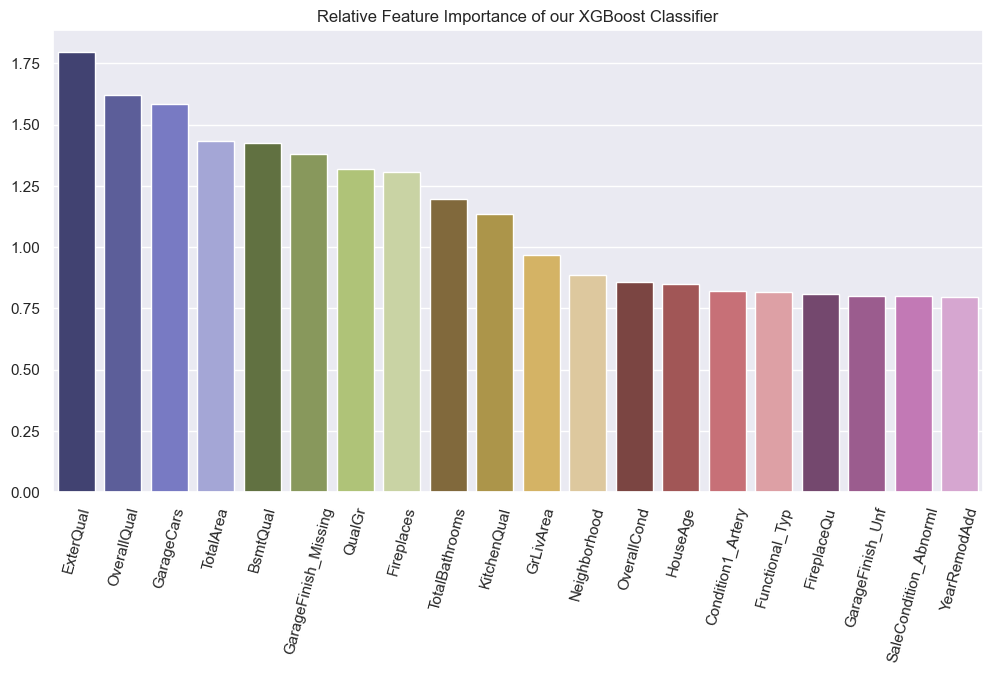

In [2331]:
xgb_pipe.fit(X, y)
importances = xgb_pipe[-1].feature_importances_
labels = xgb_pipe["preprocessor"].get_feature_names_out()
labels_no_prefix = [l.split("__")[1] for l in labels]
indices = np.argsort(-importances)
importances_dict = {}
for i in indices[:20]:
    importances_dict[labels_no_prefix[i]] = importances[i]
df_importances = pd.DataFrame(importances_dict, index=[0]) 
# df_importances.loc[:, df_importances.any()]
plt.figure(figsize=(12, 6))
ax = sns.barplot(df_importances*100, palette="tab20b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set_title("Relative Feature Importance of our XGBoost Classifier")
plt.show()

Now let's run a few other models to put into an ensemble.  I've done some light hyperparameter tuning already.  

In [2332]:
ridge_reg = Ridge(alpha=258)
scaler = StandardScaler()
ridge_search_spaces = {
    "reg__alpha": Real(0, 1000),
    "select_from_model__threshold": Real(.0001, .1)
}

ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.1)),
    ("scaler", scaler),
    ("reg", ridge_reg)
])

# find_best_params(ridge_pipe, ridge_search_spaces, X, y)
ridge_scores = cross_val_score(ridge_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
ridge_scores.mean()

np.float64(-18166.54701039778)

In [2333]:
elastic_reg = ElasticNet(alpha=1e-5, tol=1e-5)
elastic_search_spaces = {
    "reg__alpha": Real(1e-5, 1e5),
    "reg__l1_ratio": Real(0, 1),
    "reg__tol": Real(1e-5, 1e-1),
    "select_from_model__threshold": Real(.0001, .1)
}

elastic_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.0001)),
    ("scaler", scaler),
    ("reg", elastic_reg)
])

# find_best_params(elastic_pipe, elastic_search_spaces, X, y)
elastic_scores = cross_val_score(elastic_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
elastic_scores.mean()

/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e+11, tolerance: 7.249e+07
  model = cd_fast.enet_coordinate_descent(
/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e+11, tolerance: 7.592e+07
  model = cd_fast.enet_coordinate_descent(
/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the

np.float64(-17943.66584299252)

In [ ]:
sv_reg = SVR(kernel="linear", gamma="scale", epsilon=0.001, C=676)
# sv_reg = SVR()
sv_search_spaces = {
    "reg__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "reg__gamma": ["scale", "auto"],
    "reg__epsilon": Real(1e-3, 1e-2),
    "reg__C": Real(1e-3, 1e3),
    "select_from_model__threshold": Real(.0001, .1)
}

sv_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.0001)),
    ("scaler", scaler),
    ("reg", sv_reg)
])

# find_best_params(svr_pipe, svr_search_spaces, X, y)
sv_scores = cross_val_score(sv_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
sv_scores.mean()

np.float64(-17436.840002517034)

In [2335]:
rf_reg = RandomForestRegressor(max_depth=18, max_features=.2, min_samples_split=2, n_estimators=956, random_state=0)
rf_search_spaces = {
    "reg__n_estimators": Integer(100, 1000),
    "reg__max_features": Real(.2, 1.0),
    "reg__max_depth": Integer(5, 20),
    "reg__min_samples_split": Integer(2, 5),
    "select_from_model__threshold": Real(.0001, .1)
}

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.1)),
    ("reg", rf_reg)
])

# find_best_params(rf_pipe, rf_search_spaces, X, y)
rf_scores = cross_val_score(rf_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
rf_scores.mean()

np.float64(-15717.864772614184)

In [2336]:
xt_reg = ExtraTreesRegressor(max_depth=18, max_features=.734, n_estimators=1000, min_samples_split=3, random_state=0)
xt_search_spaces = {
    "reg__n_estimators": Integer(100, 1000),
    "reg__max_features": Real(.2, 1.0),
    "reg__max_depth": Integer(5, 20),
    "reg__min_samples_split": Integer(2, 5),
    "select_from_model__threshold": Real(.0001, .1)
}

xt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.05)),
    ("reg", xt_reg)
])

# find_best_params(xt_pipe, xt_search_spaces, X, y)
xt_scores = cross_val_score(xt_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
xt_scores.mean()

np.float64(-15719.006511736132)

In [2337]:
gb_reg = GradientBoostingRegressor(loss="absolute_error", max_depth=3, max_features=.356, min_samples_split=2, n_estimators=605, random_state=0)
gb_search_spaces = {
    "reg__n_estimators": Integer(100, 1000),
    "reg__max_features": Real(.1, 1.0),
    "reg__max_depth": Integer(3, 20),
    "reg__min_samples_split": Integer(2, 8),
    "select_from_model__threshold": Real(.0001, .1)
}

gb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("select_from_model", SelectFromModel(RidgeCV(), threshold=.0001)),
    ("reg", gb_reg)
])

# find_best_params(gb_pipe, gb_search_spaces, X, y)
gb_scores = cross_val_score(gb_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
gb_scores.mean()

np.float64(-14663.747970660246)

Putting it all together into voting ensemble results in a slightly better score than just using XGBoost, which was the best performing individual model.  

In [2338]:
estimators = [
    ("ridge", ridge_pipe),
    ("elastic", elastic_pipe),
    ("sv", sv_pipe),
    ("rf", rf_pipe),
    ("xt", xt_pipe),
    ("gb", gb_pipe),
    ("xgb", xgb_pipe)
]
final_estimator = RidgeCV()
# stacking_pipe = Pipeline([
#     ("reg", StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1))
# ])

voting_pipe = Pipeline([
    ("reg", VotingRegressor(estimators=estimators, weights=[1, 1, 1, 2, 2, 5, 10], n_jobs=-1))
])

# stacking_scores = cross_val_score(stacking_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
# stacking_scores.mean()
voting_scores = cross_val_score(voting_pipe, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
voting_scores.mean()

/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+11, tolerance: 7.706e+07
  model = cd_fast.enet_coordinate_descent(
/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e+11, tolerance: 7.288e+07
  model = cd_fast.enet_coordinate_descent(
/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the

np.float64(-14127.998039023636)

In [ ]:
# stacking_pipe.fit(X, y)
# y_pred_full = stacking_pipe.predict(test_df)


In [2340]:
voting_pipe.fit(X, y)
y_pred_full = voting_pipe.predict(test_df)

/Users/adrianbrudnicki/code/python/housing-prices/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+11, tolerance: 9.208e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
output = pd.DataFrame({"Id": test_df.Id, "SalePrice": y_pred_full})
output.to_csv("sub_housing.csv", index=False)